In [1]:
import sys

sys.path.append('..') # Allows imports from parent folder

In [2]:
from datasets import load_dataset
from model import NERClassifier
from preprocess_dataset import NERDataset 
from trainner import Trainner
from transformers import BertTokenizer, BertTokenizerFast
from preprocess_dataset import remove_empty_entries

import torch

In [6]:
CHECKPOINT = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizerFast.from_pretrained(CHECKPOINT)

In [7]:
data = "lener_br"
dataset = load_dataset(data)
dataset = remove_empty_entries(dataset)

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-5e59bc59f25f3d7f.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-8d0457760cd67ee6.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-74e841c1c151996a.arrow


## Hyperparameters

In [4]:
MAX_LENS = [64, 128, 256]
LEARNING_RATE=3e-4
n_labels = 13
BATCH_SIZE=8
shuffle=True
NUM_EPOCHS=1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training models with different sizes

In [5]:
import pandas as pd
from evaluator import Evaluator
from torch.utils.data import DataLoader
from transformers import AdamW

In [12]:
data = {"f1_t":[], "f1_e":[], "loss_t": [], "loss_e": []}

for MAX_LEN in MAX_LENS:
        print(f"treinando para max_len={MAX_LEN}")
        pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)
        loader = DataLoader(pytorch_dataset_train, batch_size=BATCH_SIZE, shuffle=shuffle)
        
        model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
        
        evaluator = Evaluator(loader, model, device)
        tr = Trainner(device,\
                      loader,\
                      model,\
                      optimizer,\
                      max_len=MAX_LEN,\
                      num_examples=len(pytorch_dataset_train),\
                      num_epochs=NUM_EPOCHS,\
                      evaluator=evaluator)
        print("Trainner carregado!")
        loss_t, loss_e, f1_e, f1_t = tr.train()
        print(f"Treino finalizado para max_len= {MAX_LEN}\n" + \
              f"loss_t:{loss_t}, loss_e:{loss_e}, f1_e:{f1_e}, f1_t:{f1_t}")
        data["f1_t"].append(f1_t[0]) # We return the f1 score for all epochs. Since we're using 
        data["f1_e"].append(f1_e[0]) # num_epochs=1, we'll just take the first item.
        data["loss_t"].append(loss_t[0])
        data["loss_e"].append(loss_e[0])
        del model

treinando para max_len=64


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Trainner carregado!
Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.587592840194702 f1 nas ultimas 100 iterações: 0.000993963156584516 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.4851761758327484 f1 nas ultimas 100 iterações: 0.7861392288920933 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.7291067838668823 f1 nas ultimas 100 iterações: 0.80926814077942 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 0.31220290064811707 f1 nas ultimas 100 iterações: 0.8107797851887422 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 1.0880780220031738 f1 nas ultimas 100 iterações: 0.8081338709688128 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.5058727860450745 f1 nas ultimas 100 iterações: 0.8138935339507646 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.6633578538894653 f1 nas ultimas 100 iterações: 0.7912139920184679 -

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Trainner carregado!
Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.4994595050811768 f1 nas ultimas 100 iterações: 0.001974800311970524 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.8801887631416321 f1 nas ultimas 100 iterações: 0.7879873734474648 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.779370129108429 f1 nas ultimas 100 iterações: 0.8097121026322237 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 0.5340767502784729 f1 nas ultimas 100 iterações: 0.8329601576383462 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 1.0291061401367188 f1 nas ultimas 100 iterações: 0.8123266415292558 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 1.53361177444458 f1 nas ultimas 100 iterações: 0.8242972146636486 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 1.1873161792755127 f1 nas ultimas 100 iterações: 0.8129167491593685 --

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

Trainner carregado!
Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.827531576156616 f1 nas ultimas 100 iterações: 0.0004135451003895714 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.6992560625076294 f1 nas ultimas 100 iterações: 0.80212351616958 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.5247163772583008 f1 nas ultimas 100 iterações: 0.8310989651436952 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 0.5399226546287537 f1 nas ultimas 100 iterações: 0.8298725462558114 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.1873147189617157 f1 nas ultimas 100 iterações: 0.818566937261309 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.8691987991333008 f1 nas ultimas 100 iterações: 0.8184819429731078 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.513874351978302 f1 nas ultimas 100 iterações: 0.8225453768639867 ---

In [13]:
data

{'f1_t': [0.8100718676113787, 0.8140861070692607, 0.8161770164155164],
 'f1_e': [0.8129783618496284, 0.8158356598998224, 0.8172325172494815],
 'loss_t': [0.6893169190411182, 0.6699847795594335, 0.6641292669662904],
 'loss_e': [0.6585161965854078, 0.6568699793412566, 0.6587088152050851]}

In [16]:
from matplotlib import pyplot as plt

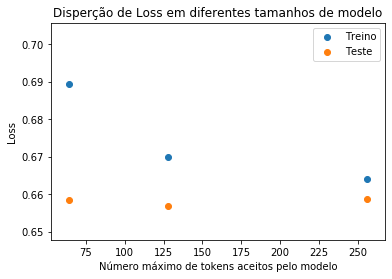

In [33]:
plt.scatter(x=MAX_LENS, y=data['loss_t'], label="Treino")
plt.scatter(x=MAX_LENS, y=data['loss_e'], label="Teste")
plt.xlabel("Número máximo de tokens aceitos pelo modelo")
plt.ylabel("Loss")
plt.title("Disperção de Loss em diferentes tamanhos de modelo")
plt.legend()
plt.show()

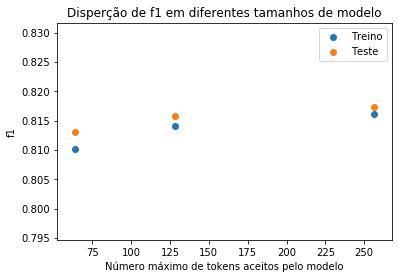

In [34]:
plt.scatter(x=MAX_LENS, y=data['f1_t'], label="Treino")
plt.scatter(x=MAX_LENS, y=data['f1_e'], label="Teste")
plt.xlabel("Número máximo de tokens aceitos pelo modelo")
plt.ylabel("f1")
plt.title("Disperção de f1 em diferentes tamanhos de modelo")
plt.legend()
plt.show()